# # Creating a project for analysis of Volve shot gathers

**Author: M.Ravasi**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os 
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import segyio

import matplotlib.pyplot as plt
import scipy.interpolate as spint

from pysubsurface.objects.rawseismic import RawSeismic

## Load velocity model

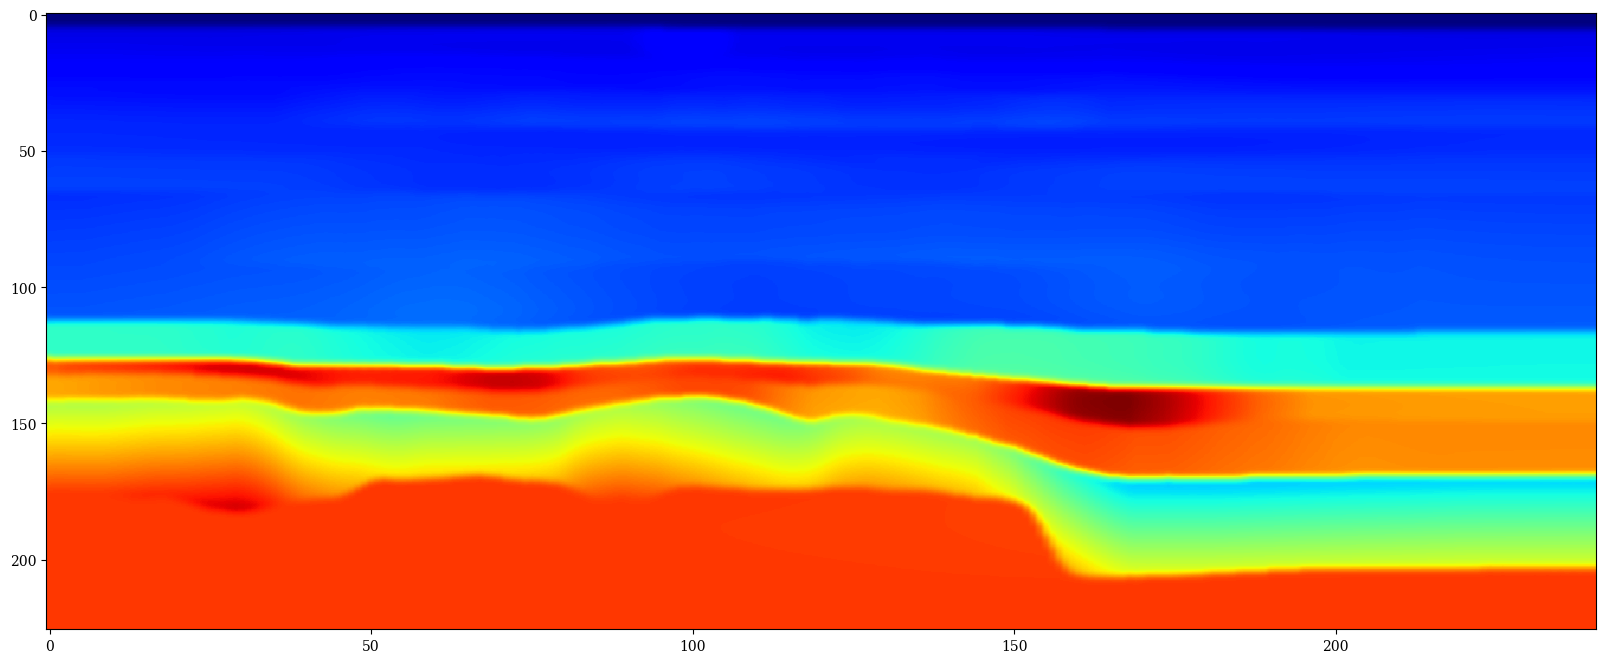

In [2]:
velfilepath = '/home/ravasim/Documents/Data/Volve/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'

fvmod = segyio.open(velfilepath)

# Load cube
vmodtr = segyio.collect(fvmod.trace[:])
vmod = segyio.cube(velfilepath)

# Load coordinates
ilvel, xlvel, zvel = fvmod.ilines, fvmod.xlines, fvmod.samples

# Load physical coordinates
scvel = fvmod.header[0][segyio.TraceField.SourceGroupScalar]
ilsvel, xlsvel = fvmod.attributes(segyio.TraceField.INLINE_3D)[:], fvmod.attributes(segyio.TraceField.CROSSLINE_3D)[:]
if (scvel<0):
    scvel=1./abs(scvel)
xvel, yvel = scvel * fvmod.attributes(segyio.TraceField.CDP_X)[:] , scvel * fvmod.attributes(segyio.TraceField.CDP_Y)[:]

# Visualization
plt.figure(figsize=(20, 8))
plt.imshow(vmod[50].T, cmap='jet')
plt.axis('tight');

## Load shot gathers

In [3]:
inputfile = '/home/ravasim/Documents/Data/Volve/ST10010_1150780_40203.sgy'
f = segyio.open(inputfile, ignore_geometry=True)
print(segyio.tools.wrap(f.text[0]))    

C 1 CLIENT: STATOIL           COMPANY: RESERVOIR EXPLORATION TECHNOLOGY
C 2 AREA: VOLVE NORWAY BLOCK 15/9                SURVEY: ST10010
C 3 SWATH:  11                             VESSELS:M/V VIKLAND, M/V SANCO
SPIRITC 4 RCV LINE: 1150780    RCVR RANGE: 1239-1717
C 5 DATA-SET: NAV MERGE   TRACES PER RECORD: 240 X 4   SEQ: 094-133
C 6 RECORDING FORMAT: IEEE SEG-Y           FORMAT THIS REEL: SEG-Y 3592
C 7 SAMPLE CODE: FLOATING PT               PROCESSED: 03/11/2010
C 8 ACQ. GEOM: 8 ROLL 8  INLINE SWATH      LINE PREFIX: ST10010
C 9 INSTRUMENT: VECTORSEIS OCEAN BOTTOM    RECORDING SYSTEM DELAY: 0 MS
C10 RECORDING FILTER: 1.5/6-187/260MIN PHS DESCRIPTION: HZ/DB PER OCTAVE
C11 NO OF RECEIVER LINES/SWATH: 8          RECEIVER LINE SEPARATION: 400/200M
C12 ACTIVE CABLE LENGTH: 5975M             RCVRS / RCV LINE 240 X 4
C13 NO OF SOURCES:  2                      SOURCE SEPARATION: 50M
C14 RECEIVER INTERVAL: 25M                 SHOT INTERVAL: 25M, FLIP/FLOP
C15 DATUM: ED50, 31N  SPHEROID: INT. 

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109


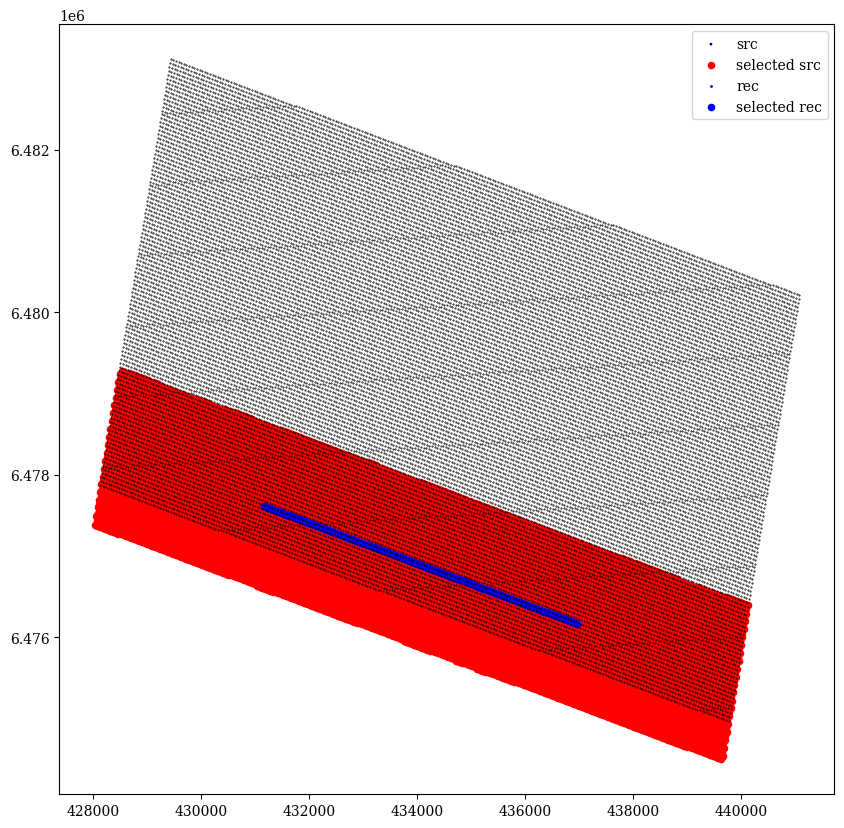

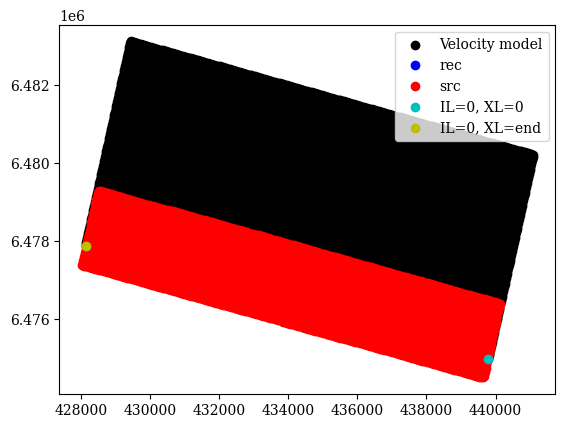

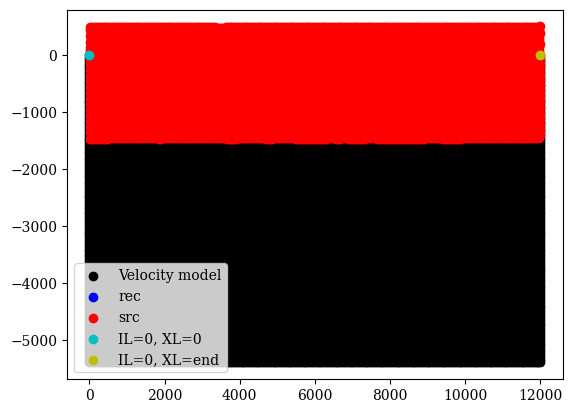

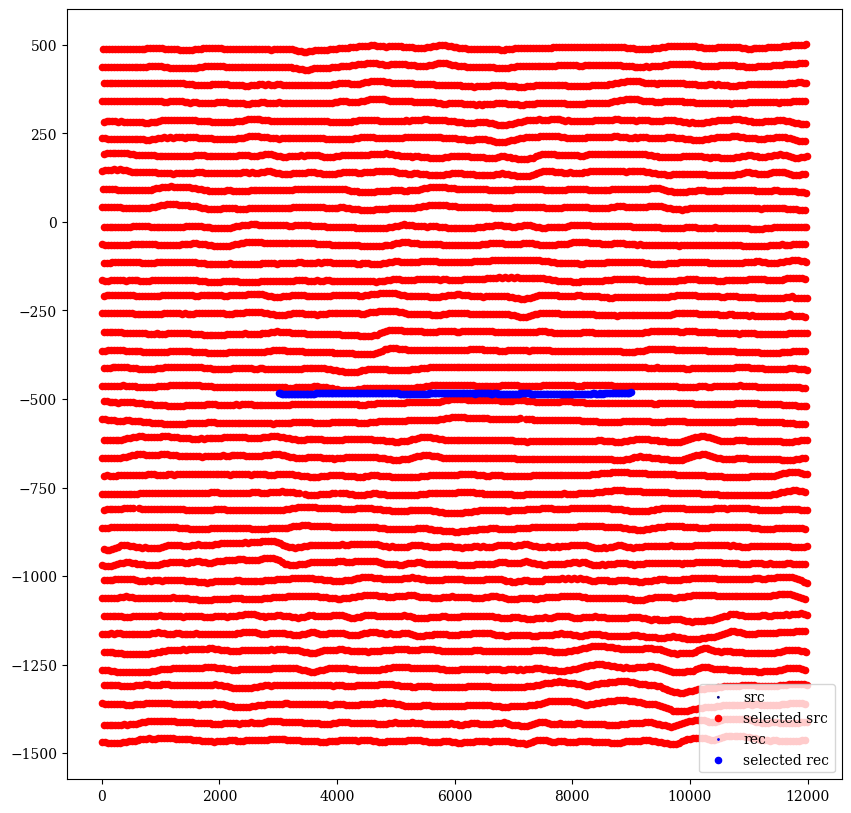

In [4]:
# Create RawSeismic object
sg = RawSeismic(inputfile, components=['P', 'VZ', 'VX', 'VY'])
sg.interpret()

# Display geometry
sg.showgeometry()
plt.scatter(xvel, yvel, c='k', s=.2)

# Rotate geometry to be along x-y coordinate system
_,_,_,_, (xvel_local, yvel_local) = sg.rotategeometry(velfile=velfilepath, plotflag=1)
sg.showgeometry(local=True)

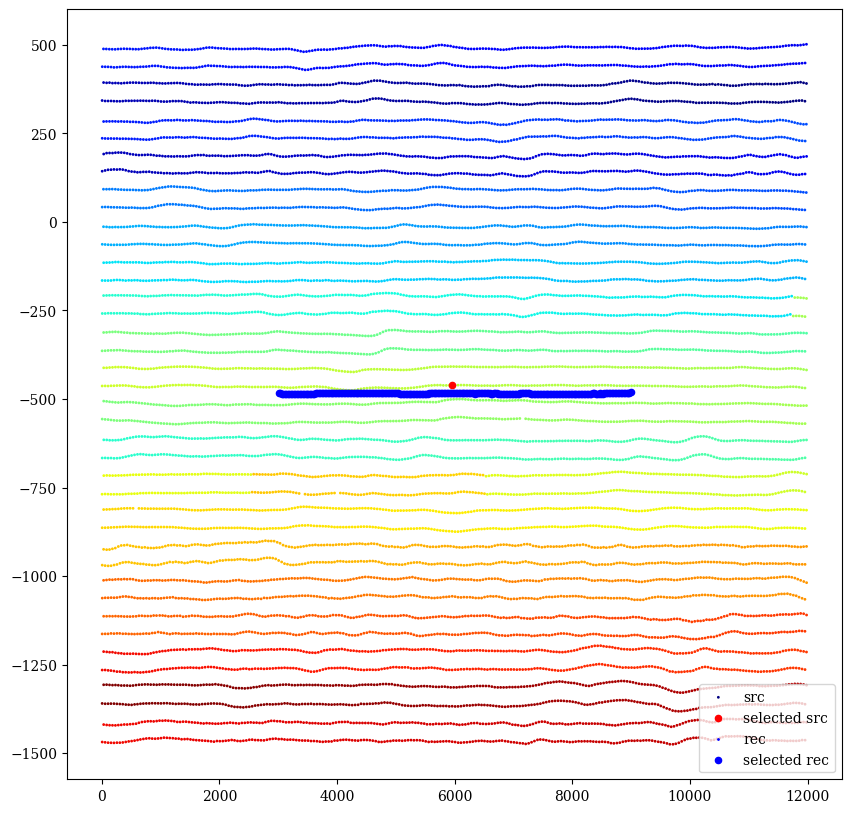

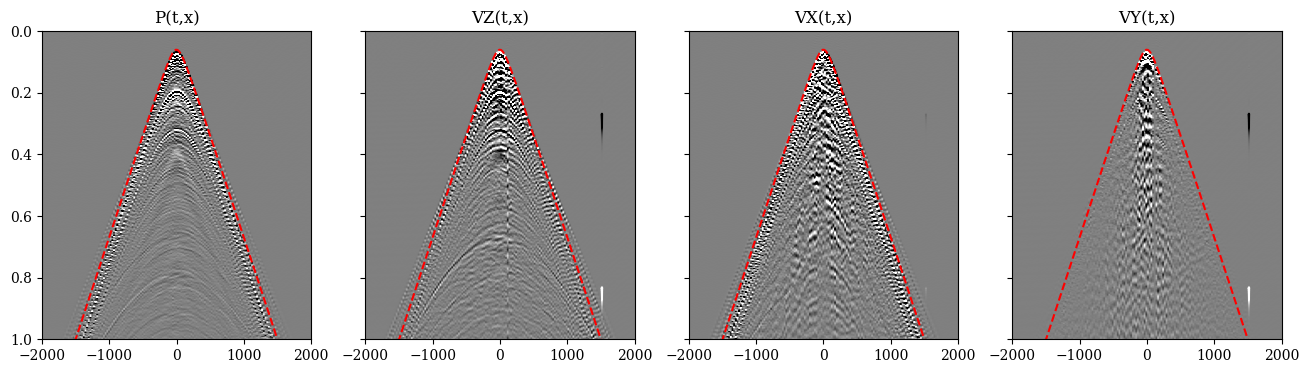

In [5]:
# Select one shot and set of receivers (2D line)
ishotc = 5520
ishotin, ishotend = ishotc-120, ishotc+120
irecin, irecend = 30, 210
vwater = 1500.

sg.selectsrcs(ishotc, ishotc+1, plotflag=False)
sg.showgeometry(local=True)

# Load shot gather
shot = sg.get_shotgather(ishotc)

# Compute direct arrival
drec = np.mean(np.abs(np.diff(sg.recx_local)))
offset = np.sqrt((sg.srcx[ishotc] - sg.recx) ** 2 + (sg.srcy[ishotc] - sg.recy) ** 2)
distance = np.sqrt((sg.srcz[ishotc] - sg.recz) ** 2 + \
                   (sg.srcx[ishotc] - sg.recx) ** 2 + \
                   (sg.srcy[ishotc] - sg.recy) ** 2)
tdir = distance / vwater
offsetreg = np.linspace(-offset[0], offset[-1], sg.nrec)

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))
axs[0].imshow(shot['P'].T, cmap='gray', vmin=-5e6, vmax=5e6,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[0].plot(offsetreg, tdir, '--r')
axs[0].set_title('P(t,x)')
axs[0].axis('tight')
axs[1].imshow(shot['VZ'].T, cmap='gray', vmin=-1e5, vmax=1e5,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[1].plot(offsetreg, tdir, '--r')
axs[1].set_title('VZ(t,x)')
axs[1].axis('tight')
axs[1].set_ylim(4, 0)
axs[2].imshow(shot['VX'].T, cmap='gray', vmin=-1e5, vmax=1e5,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[2].plot(offsetreg, tdir, '--r')
axs[2].set_title('VX(t,x)')
axs[2].axis('tight')
axs[2].set_ylim(4, 0)
axs[3].imshow(shot['VY'].T, cmap='gray', vmin=-1e5, vmax=1e5,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[3].plot(offsetreg, tdir, '--r')
axs[3].set_title('VY(t,x)')
axs[3].axis('tight')
axs[3].set_ylim(1., 0)
axs[3].set_xlim(-2000, 2000);

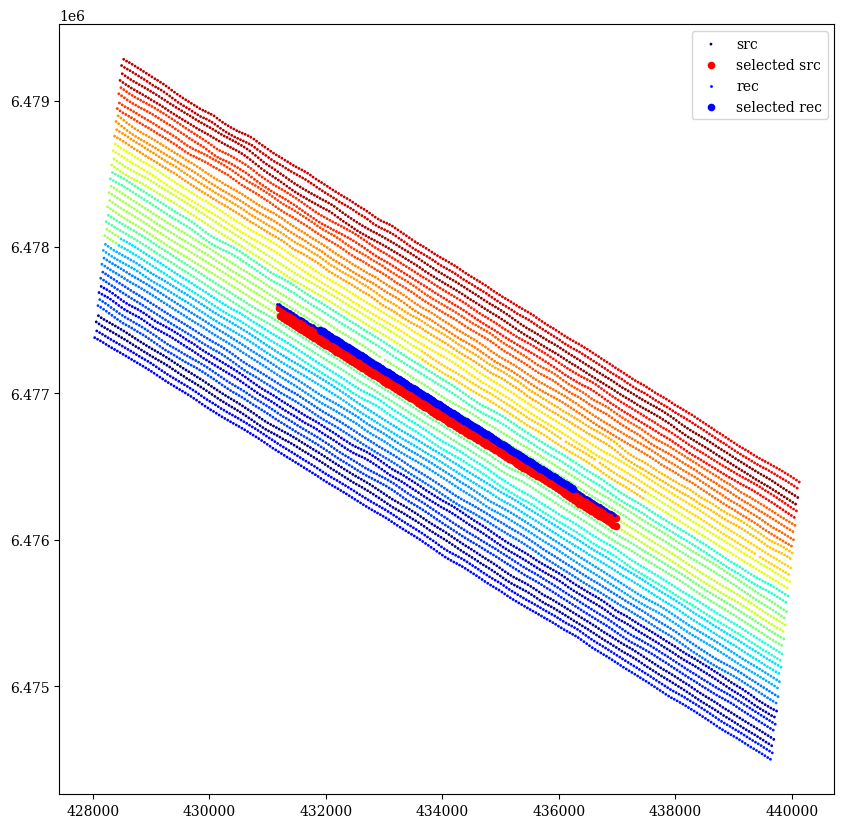

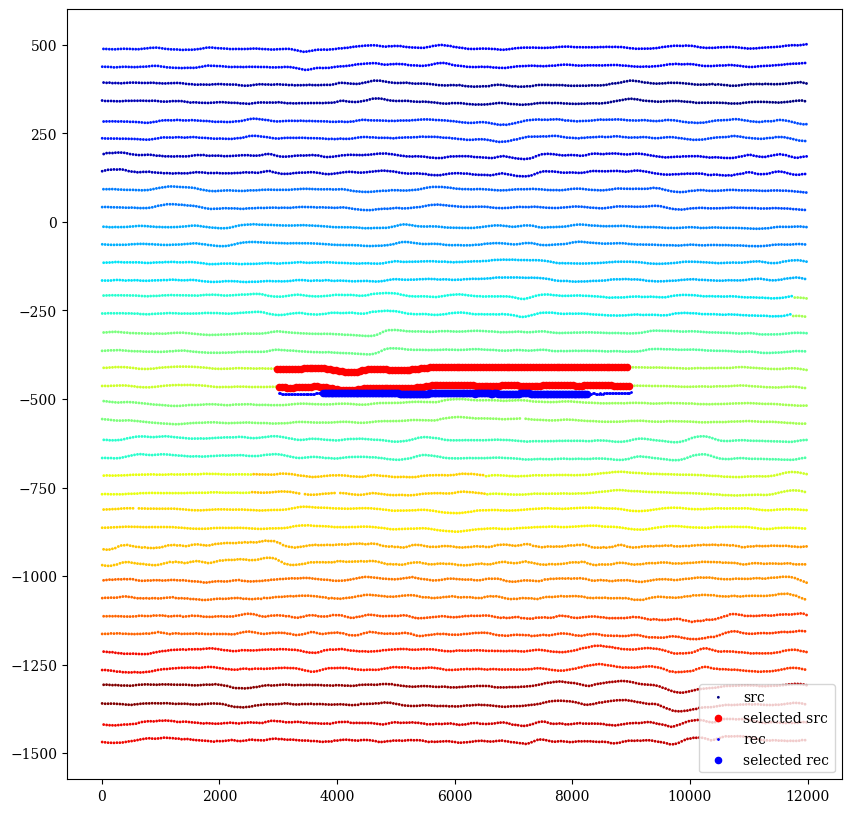

In [6]:
sg.selectrecs(irecin, irecend, plotflag=False)
sg.selectsrcs(ishotin, ishotend, plotflag=False)
sg.showgeometry()
sg.showgeometry(local=True)

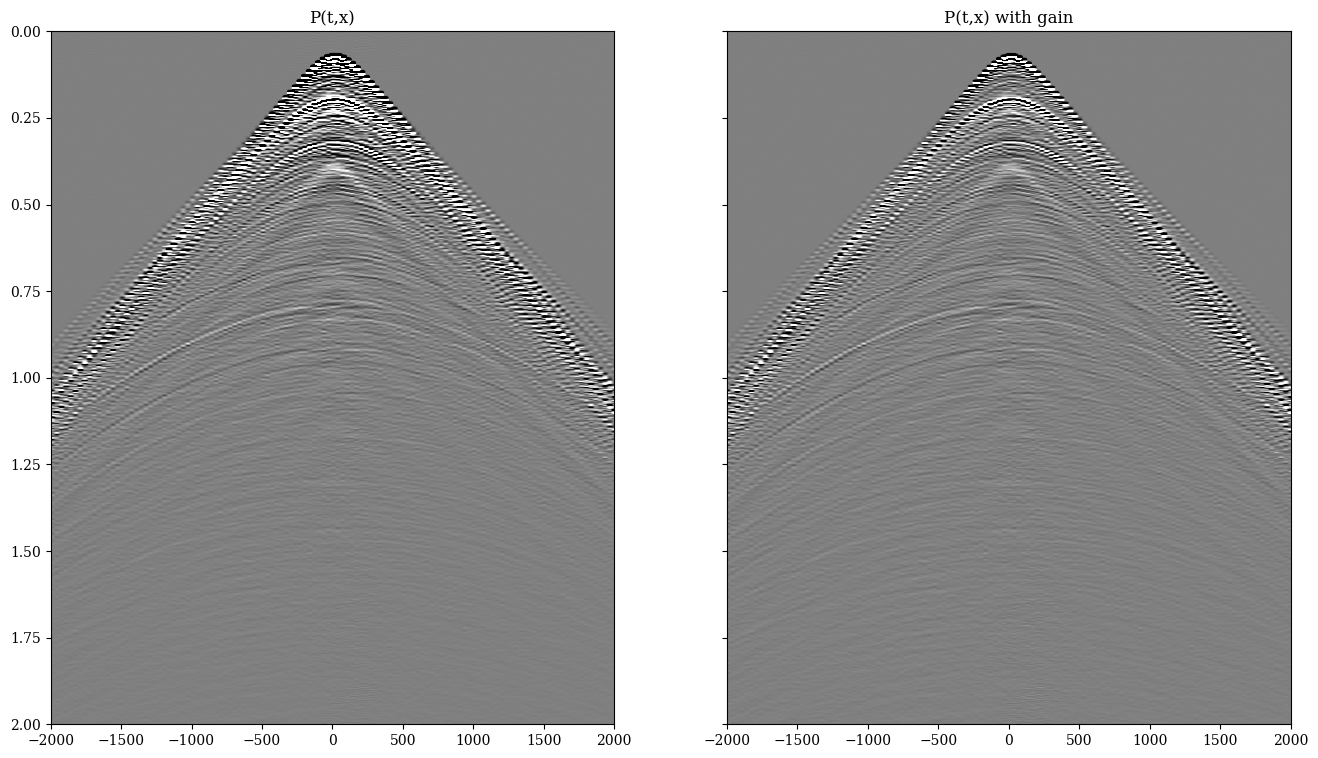

In [7]:
# Raw data
shot = sg.get_shotgather(ishotc)
gain = np.sqrt(sg.t)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 9))
axs[0].imshow(shot['P'].T, cmap='gray', vmin=-3e6, vmax=3e6,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[0].set_title('P(t,x)')
axs[0].axis('tight')
axs[1].imshow(shot['P'].T * gain[:, np.newaxis], cmap='gray', vmin=-3e6, vmax=3e6,
              extent = (-offset[0], offset[-1], sg.t[-1], sg.t[0]))
axs[1].set_title('P(t,x) with gain')
axs[1].axis('tight')
axs[1].set_ylim(2., 0)
axs[1].set_xlim(-2000, 2000);

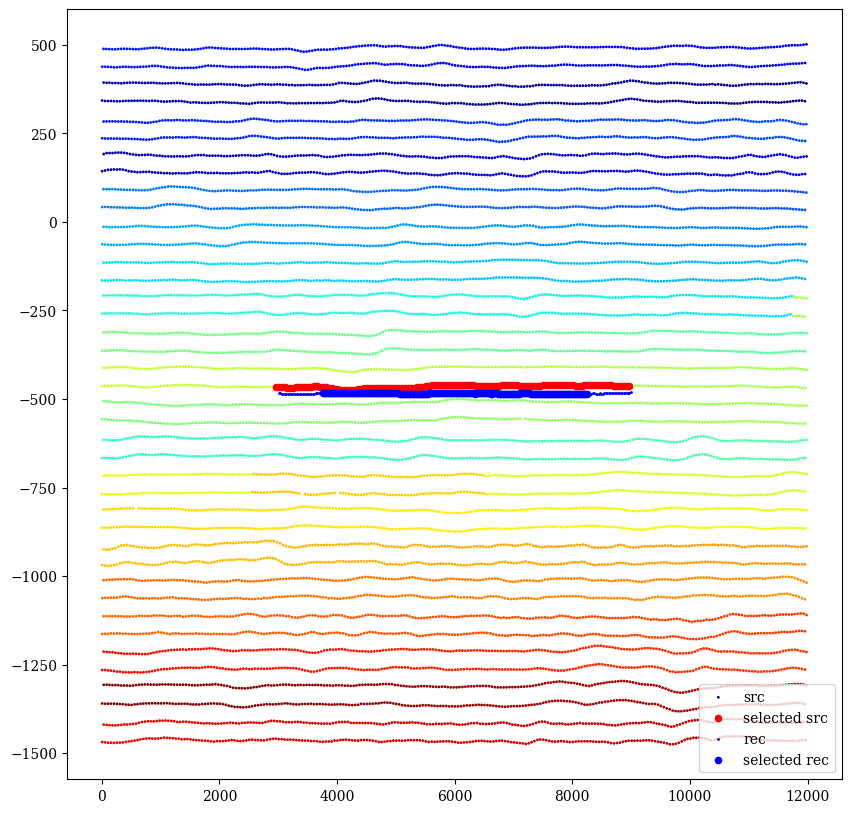

In [8]:
# Select multiple shots are receivers
startshot=ishotc-120
endshot=ishotc+120
jshot = 2
nshots = int((endshot - startshot) // jshot)

# Geometry
sg.selectrecs(irecin, irecend, plotflag=False)
sg.selectsrcs(startshot, endshot+1, jshot, plotflag=False)
sg.showgeometry(local=True)

nshots = len(sg.selected_src)
nrecs = len(sg.selected_rec)


# Data
shots = []
zo = []
for i, ishot in enumerate(range(startshot, endshot, jshot)):
    # save shot gather
    shots.append(sg.get_shotgather(ishot)['P'])
    
    # read geometry for selected shot
    src_x = sg.srcx_local[ishot]
    src_y = sg.srcy_local[ishot]
    src_z = sg.srcz[ishot]
    
    nrec = len(sg.selected_rec)
    rec_x = sg.recx_local[sg.selected_rec]
    rec_y = sg.recy_local[sg.selected_rec]
    rec_z = sg.recz[sg.selected_rec]

    # compute offset
    offset_x = np.sqrt((src_x - rec_x) ** 2)
    offset = np.sqrt((src_x - rec_x) ** 2 + (src_y - rec_y) ** 2)

    # extract zerooffset trace
    zotrace = np.argmin(offset)
    zo.append(shots[i][zotrace])
    
shots = np.concatenate(shots).reshape(len(shots), shots[0].shape[0], shots[0].shape[1])
zo = np.concatenate(zo).reshape(len(zo), zo[0].shape[0])

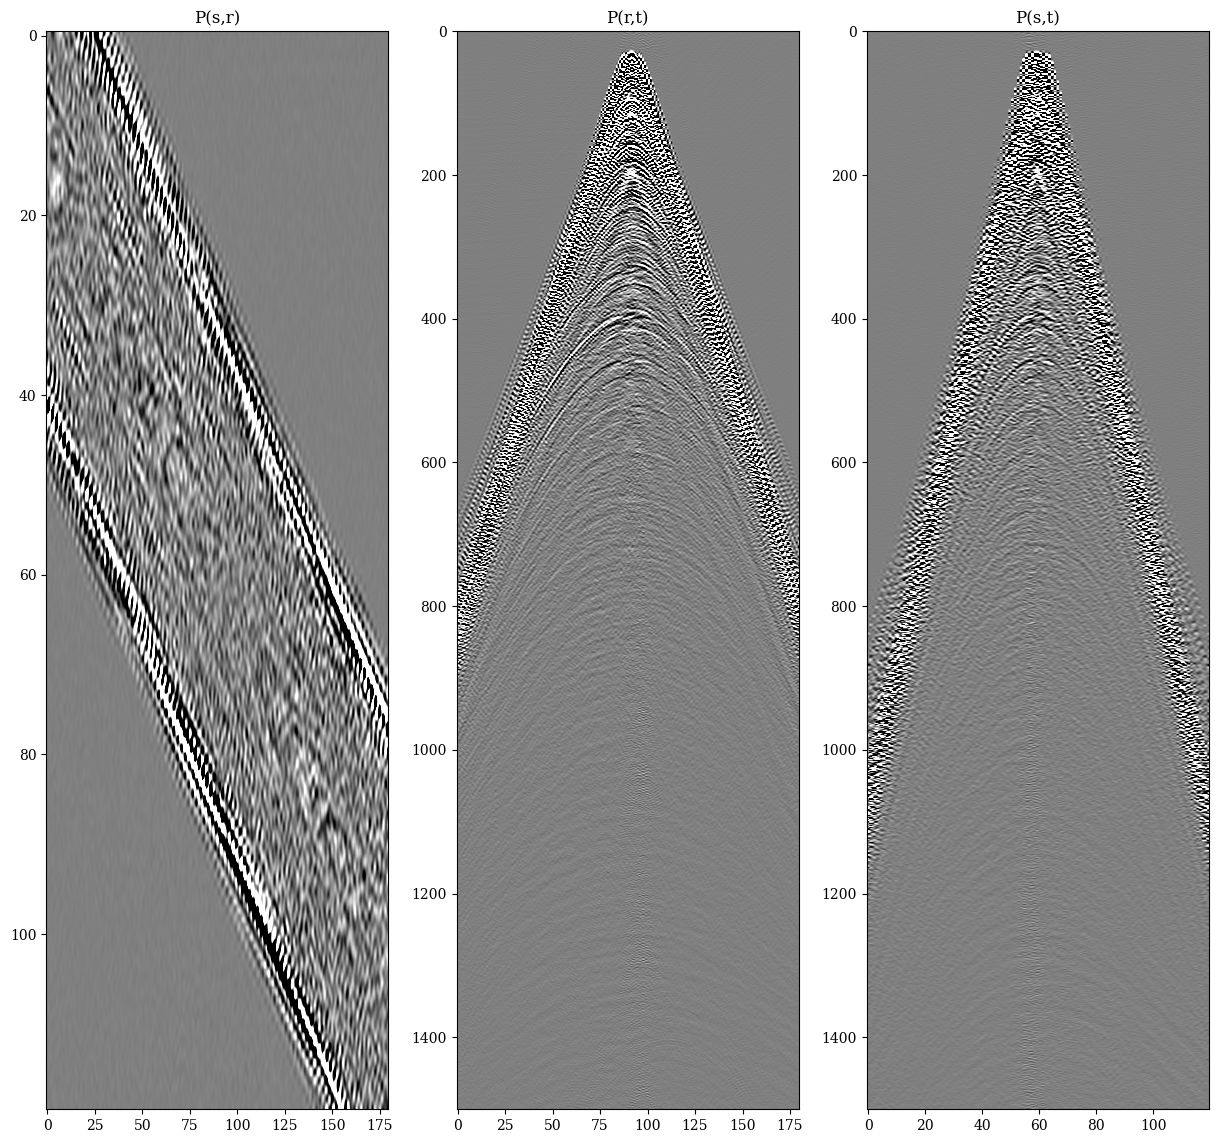

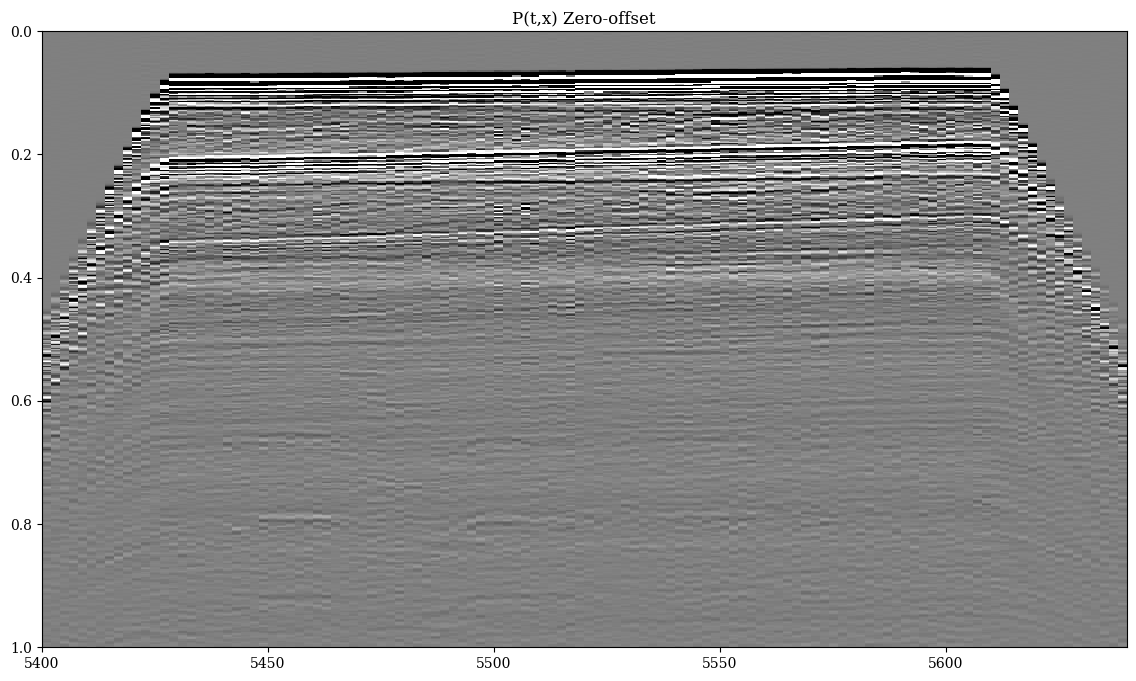

In [10]:
# Visualization

clip = 1e6
fig, axs = plt.subplots(1, 3, figsize=(15, 14))
axs[0].imshow(shots[..., 500], cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[0].set_title('P(s,r)')
axs[0].axis('tight')

axs[1].imshow(shots[nshots//2].T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[1].set_title('P(r,t)')
axs[1].axis('tight')
axs[1].set_ylim(1500, 0)

axs[2].imshow(shots[:, nrecs//2].T, cmap='gray', vmin=-clip, vmax=clip, interpolation='sinc')
axs[2].set_title('P(s,t)')
axs[2].axis('tight')
axs[2].set_ylim(1500, 0);

clip = 1e7
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.imshow(zo.T, cmap='gray', vmin=-clip, vmax=clip, interpolation='none',
              extent=(startshot, endshot, sg.t[-1], sg.t[0]))
ax.set_title('P(t,x) Zero-offset')
ax.axis('tight')
ax.set_ylim(1., 0.);